In [1]:
import pandas as pd

### kaggle의 타이타닉 데이터 이용
https://www.kaggle.com/c/titanic

In [102]:
train=pd.read_csv("./titanic/train.csv")
test=pd.read_csv("./titanic/test.csv")

In [5]:
!pip install xgboost

In [7]:
!pip install plotly

  Stored in directory: C:\Users\cloud\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [103]:
# Load in our libraries
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC


In [104]:
full_data=[train,test]


train["Name_length"]=train["Name"].apply(len)
test["Name_length"]=test["Name"].apply(len)

In [105]:
train["Has_Cabin"]=train["Cabin"].apply(lambda x:0 if type(x)==float else 1)
test["Has_Cabin"]=test["Cabin"].apply(lambda x:0 if type(x)==float else 1)

for dataset in full_data:
    dataset["Family"]=dataset["SibSp"]+dataset["Parch"]+1

for dataset in full_data:
    dataset["IsAlone"]=0
    dataset.loc[dataset["Family"]==1,"IsAlone"]=1


In [106]:
#결측치 처리

for dataset in full_data:
    dataset["Embarked"]=dataset["Embarked"].fillna("S")
    
for dataset in full_data:
    dataset["Fare"]=dataset["Fare"].fillna(train["Fare"].median())
    

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std,
                                             age_avg + age_std, 
                                             size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    

In [107]:
#train["Fare"]의 데이터 수를 동일한 수로 4등분 시키기
train["CatagoricalFare"]=pd.qcut(train["Fare"],4)

#train["Age"]의 데이터 범위를 동일한 범위로 5등분시키기
train["CategoricalAge"]=pd.cut(train["Age"],5)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null object
Age                891 non-null int32
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           891 non-null object
Name_length        891 non-null int64
Has_Cabin          891 non-null int64
Family             891 non-null int64
IsAlone            891 non-null int64
CatagoricalFare    891 non-null category
CategoricalAge     891 non-null category
dtypes: category(2), float64(1), int32(1), int64(9), object(5)
memory usage: 109.9+ KB


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Name_length    418 non-null int64
Has_Cabin      418 non-null int64
Family         418 non-null int64
IsAlone        418 non-null int64
dtypes: float64(1), int32(1), int64(8), object(5)
memory usage: 47.4+ KB


In [26]:
#현재 결측치는 Cabin만 존재

#하지만 너무 많은 결측치로 인해 이를 생략하고 신경쓰지 않는 것으로 가자.

In [59]:
dataset["Ticket"].unique()

#너무 범위가 장황해
#Ticket도 패스!

array(['330911', '363272', '240276', '315154', '3101298', '7538',
       '330972', '248738', '2657', 'A/4 48871', '349220', '694', '21228',
       '24065', 'W.E.P. 5734', 'SC/PARIS 2167', '233734', '2692',
       'STON/O2. 3101270', '2696', 'PC 17603', 'C 17368', 'PC 17598',
       'PC 17597', 'PC 17608', 'A/5. 3337', '113509', '2698', '113054',
       '2662', 'SC/AH 3085', 'C.A. 31029', 'C.A. 2315', 'W./C. 6607',
       '13236', '2682', '342712', '315087', '345768', '1601', '349256',
       '113778', 'SOTON/O.Q. 3101263', '237249', '11753',
       'STON/O 2. 3101291', 'PC 17594', '370374', '11813', 'C.A. 37671',
       '13695', 'SC/PARIS 2168', '29105', '19950', 'SC/A.3 2861',
       '382652', '349230', '348122', '386525', '349232', '237216',
       '347090', '334914', 'F.C.C. 13534', '330963', '113796', '2543',
       '382653', '349211', '3101297', 'PC 17562', '113503', '359306',
       '11770', '248744', '368702', '2678', 'PC 17483', '19924', '349238',
       '240261', '2660', '3308

In [27]:
#상관관계를 알아보기 위해 범위가 너무 넓은 데이터셋을 나누어주자.
#Age, Fare

#수치형으로 되어져 있지 않는 데이터 셋은 수치형으로 바꿔주자.

#Name, Sex, Embarked


In [33]:
#Name

train["Name"].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [108]:
#정규식 이용

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [109]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [42]:
train["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [43]:
test["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [110]:
#Mlle, Ms는 Miss를 의미,  Mme는 Mrs를 의미

for dataset in full_data:
    dataset["Title"]=dataset["Title"].replace("Mlle","Miss")
    dataset["Title"]=dataset["Title"].replace("Ms","Miss")
    dataset["Title"]=dataset["Title"].replace("Mme","Mrs")
    
    dataset["Title"]=dataset["Title"].replace(['Don', 'Rev', 'Dr',
       'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Dona',
       'Jonkheer'],"rare")

In [111]:
dataset["Title"].unique()  #잘 바뀌어졌군

array(['Mr', 'Mrs', 'Miss', 'Master', 'rare'], dtype=object)

In [112]:
#Mapping 이용

for dataset in full_data:
    #Name
    dataset["Title"]=dataset["Title"].map({'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4, 'rare':5})
    #Sex
    dataset["Sex"]=dataset["Sex"].map({"male":1,"female":2})
    #Embarked
    dataset["Embarked"]=dataset["Embarked"].map({"C":1,"Q":2,"S":3})

In [53]:
train["CategoricalAge"]

0       (16.0, 32.0]
1       (32.0, 48.0]
2       (16.0, 32.0]
3       (32.0, 48.0]
4       (32.0, 48.0]
5       (16.0, 32.0]
6       (48.0, 64.0]
7      (-0.08, 16.0]
8       (16.0, 32.0]
9      (-0.08, 16.0]
10     (-0.08, 16.0]
11      (48.0, 64.0]
12      (16.0, 32.0]
13      (32.0, 48.0]
14     (-0.08, 16.0]
15      (48.0, 64.0]
16     (-0.08, 16.0]
17      (32.0, 48.0]
18      (16.0, 32.0]
19      (16.0, 32.0]
20      (32.0, 48.0]
21      (32.0, 48.0]
22     (-0.08, 16.0]
23      (16.0, 32.0]
24     (-0.08, 16.0]
25      (32.0, 48.0]
26      (16.0, 32.0]
27      (16.0, 32.0]
28      (16.0, 32.0]
29      (16.0, 32.0]
           ...      
861     (16.0, 32.0]
862     (32.0, 48.0]
863    (-0.08, 16.0]
864     (16.0, 32.0]
865     (32.0, 48.0]
866     (16.0, 32.0]
867     (16.0, 32.0]
868     (16.0, 32.0]
869    (-0.08, 16.0]
870     (16.0, 32.0]
871     (32.0, 48.0]
872     (32.0, 48.0]
873     (32.0, 48.0]
874     (16.0, 32.0]
875    (-0.08, 16.0]
876     (16.0, 32.0]
877     (16.0

In [ ]:
#Age의 기준은 16,32,48,64이군

In [57]:
train["CatagoricalFare"]

0       (-0.001, 7.91]
1      (31.0, 512.329]
2       (7.91, 14.454]
3      (31.0, 512.329]
4       (7.91, 14.454]
5       (7.91, 14.454]
6      (31.0, 512.329]
7       (14.454, 31.0]
8       (7.91, 14.454]
9       (14.454, 31.0]
10      (14.454, 31.0]
11      (14.454, 31.0]
12      (7.91, 14.454]
13     (31.0, 512.329]
14      (-0.001, 7.91]
15      (14.454, 31.0]
16      (14.454, 31.0]
17      (7.91, 14.454]
18      (14.454, 31.0]
19      (-0.001, 7.91]
20      (14.454, 31.0]
21      (7.91, 14.454]
22      (7.91, 14.454]
23     (31.0, 512.329]
24      (14.454, 31.0]
25     (31.0, 512.329]
26      (-0.001, 7.91]
27     (31.0, 512.329]
28      (-0.001, 7.91]
29      (-0.001, 7.91]
            ...       
861     (7.91, 14.454]
862     (14.454, 31.0]
863    (31.0, 512.329]
864     (7.91, 14.454]
865     (7.91, 14.454]
866     (7.91, 14.454]
867    (31.0, 512.329]
868     (7.91, 14.454]
869     (7.91, 14.454]
870     (-0.001, 7.91]
871    (31.0, 512.329]
872     (-0.001, 7.91]
873     (7.

In [58]:
#Fare의 기준은 7.91, 14.454 ,31이군.

In [113]:
for dataset in full_data:
    #Age
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
    #Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']  = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] >=31, 'Fare']  = 3

In [114]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,Family,IsAlone,CatagoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0.0,NaN,3,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,2,1,0,PC 17599,3.0,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",2
2,3,1,3,"Heikkinen, Miss. Laina",2,1,0,0,STON/O2. 3101282,1.0,NaN,3,22,0,1,1,"(7.91, 14.454]","(16.0, 32.0]",3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,2,1,0,113803,3.0,C123,3,44,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",2
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1.0,NaN,3,24,0,1,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [115]:
#이제 필요없는 셋은 없애보자

train=train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'],axis=1)
train=train.drop(['CategoricalAge',"CatagoricalFare"],axis=1)

test=test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'],axis=1)

In [116]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'Family', 'IsAlone', 'Title'],
      dtype='object')

In [117]:
test.columns

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'Family', 'IsAlone', 'Title'],
      dtype='object')

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null int32
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int64
Name_length    891 non-null int64
Has_Cabin      891 non-null int64
Family         891 non-null int64
IsAlone        891 non-null int64
Title          891 non-null int64
dtypes: float64(1), int32(1), int64(10)
memory usage: 80.1 KB


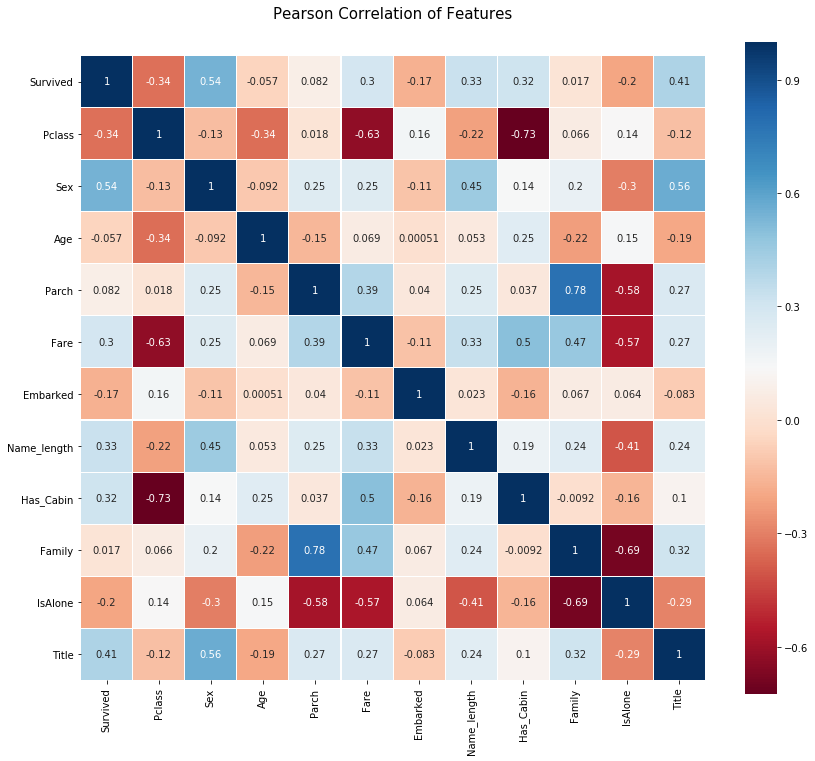

In [119]:
#히트맵 이용


colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


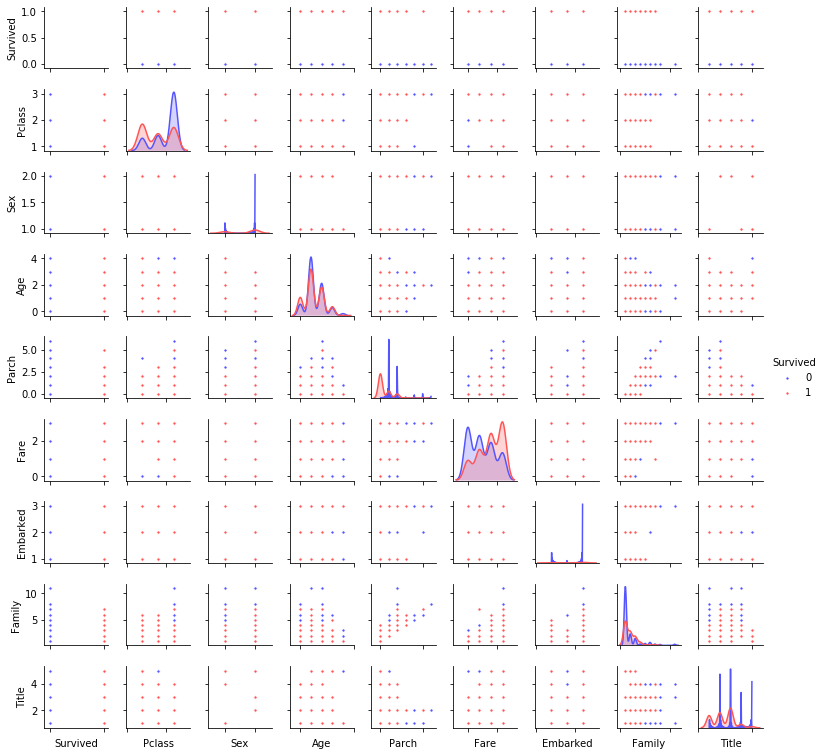

In [120]:
#상관관계를 그래프를 통해 알아보면

g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'Family', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])